<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


When TD(5) finds a reward, it propagates information backwards; by contrast, SARSA only updates the value of the current action. Therefore, TD(5) converges faster than SARSA (as the graph shows), and their final episode returns are similar.

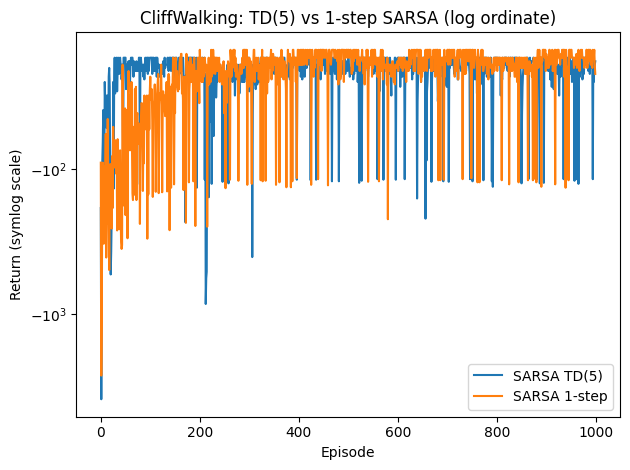

In [7]:
"""
SARSA with TD(5) on CliffWalking-v1 + 1-step SARSA comparison
Plot uses a logarithmic y-axis (no smoothing).

Requirements:
  pip install gymnasium numpy matplotlib
  pip install "gymnasium[toy_text]"   # for CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
from typing import Tuple, List, Optional

# ----------------------------
# Utilities
# ----------------------------
def epsilon_greedy(Q: np.ndarray, state: int, epsilon: float, n_actions: int) -> int:
    """ε-greedy over Q[s]."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return int(np.argmax(Q[state]))

# ----------------------------
# SARSA TD(n)
# ----------------------------
def sarsa_td_n(
    env_name: str = "CliffWalking-v1",
    n_step: int = 5,
    n_episodes: int = 5000,
    alpha: float = 0.1,
    gamma: float = 0.99,
    epsilon: float = 0.1,
    seed: Optional[int] = 0,
) -> Tuple[np.ndarray, List[float]]:
    """
    On-policy SARSA with TD(n) (default n=5).
    Returns:
      Q: action-value table
      episode_returns: sum of rewards per episode
    """
    env = gym.make(env_name)
    if seed is not None:
        env.reset(seed=seed)
        np.random.seed(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=float)

    episode_returns: List[float] = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon, n_actions)

        # Trajectory buffers (indexed 0..t)
        states, actions, rewards = deque(), deque(), deque()

        T = float("inf")  # time step of terminal transition
        t = 0

        while True:
            if t < T:
                # Step environment using current (state, action)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = bool(terminated or truncated)

                # Log current transition pieces (s_t, a_t, r_t)
                states.append(state)
                actions.append(action)
                rewards.append(reward)

                if done:
                    T = t + 1
                else:
                    # Choose next action on-policy
                    next_action = epsilon_greedy(Q, next_state, epsilon, n_actions)
                    # Advance current pointers to (t+1) pair for potential bootstrapping
                    state, action = next_state, next_action

            tau = t - n_step + 1
            if tau >= 0:
                # ------- Compute n-step return G(tau) -------
                G = 0.0
                # upper = min(tau+n, T) but avoid int(inf)
                upper = (tau + n_step) if T == float("inf") else min(tau + n_step, int(T))
                # accumulate rewards: r_tau ... r_{upper-1}
                for i in range(tau, upper):
                    G += (gamma ** (i - tau)) * rewards[i]

                # Bootstrap with Q(s_{tau+n}, a_{tau+n}) if tau+n < T
                if (T == float("inf")) or (tau + n_step < int(T)):
                    idx = tau + n_step
                    # If idx already in buffers, use it; if idx == t+1, use current (state, action)
                    if idx <= t:
                        s_tau_n = states[idx]
                        a_tau_n = actions[idx]
                    else:
                        # idx == t+1 (the next pair not yet appended)
                        s_tau_n = state
                        a_tau_n = action
                    G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

                # ------- Update -------
                s_tau, a_tau = states[tau], actions[tau]
                Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

            if tau == T - 1:
                break
            t += 1

        episode_returns.append(sum(rewards))

    env.close()
    return Q, episode_returns

# ----------------------------
# Baseline: 1-step SARSA
# ----------------------------
def sarsa_1step(
    env_name: str = "CliffWalking-v1",
    n_episodes: int = 1000,
    alpha: float = 0.1,
    gamma: float = 0.99,
    epsilon: float = 0.1,
    seed: Optional[int] = 0,
) -> Tuple[np.ndarray, List[float]]:
    """Standard on-policy 1-step SARSA."""
    env = gym.make(env_name)
    if seed is not None:
        env.reset(seed=seed)
        np.random.seed(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=float)

    episode_returns: List[float] = []

    for _ in range(n_episodes):
        s, _ = env.reset()
        a = epsilon_greedy(Q, s, epsilon, n_actions)
        G = 0.0

        while True:
            s_next, r, terminated, truncated, _ = env.step(a)
            done = bool(terminated or truncated)

            if not done:
                a_next = epsilon_greedy(Q, s_next, epsilon, n_actions)
                td_target = r + gamma * Q[s_next, a_next]
            else:
                a_next = None
                td_target = r

            Q[s, a] += alpha * (td_target - Q[s, a])
            G += r

            if done:
                break
            s, a = s_next, a_next

        episode_returns.append(G)

    env.close()
    return Q, episode_returns

# ----------------------------
# Main: train & log-scale plot
# ----------------------------
if __name__ == "__main__":
    N_EPISODES = 1000
    ALPHA = 0.1
    GAMMA = 0.99
    EPSILON = 0.1
    N = 5
    SEED = 0  # set None for stochastic runs

    # Train TD(5)
    Q5, returns5 = sarsa_td_n(
        n_step=N,
        n_episodes=N_EPISODES,
        alpha=ALPHA,
        gamma=GAMMA,
        epsilon=EPSILON,
        seed=SEED,
    )

    # Train 1-step SARSA
    Q1, returns1 = sarsa_1step(
        n_episodes=N_EPISODES,
        alpha=ALPHA,
        gamma=GAMMA,
        epsilon=EPSILON,
        seed=SEED,
    )

    # Plot learning curves using a logarithmic y-axis that supports negatives
    plt.figure()
    plt.plot(returns5, label=f"SARSA TD({N})")
    plt.plot(returns1, label="SARSA 1-step")
    plt.xlabel("Episode")
    plt.ylabel("Return (symlog scale)")
    plt.title("CliffWalking: TD(5) vs 1-step SARSA (log ordinate)")
    plt.yscale("symlog")  # handles both negative and positive returns
    plt.legend()
    plt.tight_layout()
    plt.show()


## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
